Message-passing neural network (MPNN) for molecular property prediction

## 소개

이 튜토리얼에서는 그래프 신경망(GNN) 유형을 구현합니다. _ 그래프 속성을 예측하기 위해 MPNN(신경망 network_)을 전달하는 메시지입니다. 특히, 우리는 MPNN을 구현하여 혈액-뇌 장벽 투과성(BBBP)으로 알려진 분자 특성을 예측합니다.

동기 부여 : 분자는 자연스럽게 무 방향 그래프로 표현되기 때문에, 여기서 는 집합 또는 꼭짓점(노드, 원자)과 가장자리 집합(결합), GNN(예: MPNN)은 분자 특성을 예측하는 데 유용한 방법임이 입증되었습니다.G = (V, E)VE

지금까지는 랜덤 포레스트, 서포트 벡터 머신 등과 같은 보다 전통적인 방법, 분자 특성을 예측하는 데 일반적으로 사용되었습니다. GNN과 달리 전통적인 접근법은 종종 다음과 같이 미리 계산 된 분자 특징에 대해 작동합니다. 분자량, 극성, 전하, 탄소 원자 수 등 비록 이것들 분자 특징은 다양한 분자 특성에 대한 좋은 예측 인자임이 입증되었습니다. 이러한 더 "원시적인", "낮은 수준"의 기능에서 작동하는 것이 균일하다는 가설을 세웠습니다. 더 좋은.

참조
최근 몇 년 동안 신경망 개발에 많은 노력을 기울였습니다. 분자 그래프를 포함한 그래프 데이터. 그래프 신경망에 대한 요약은 예를 들어, 그래프 신경망 및 그래프 신경망에 대한 종합 조사: 방법 및 응용 프로그램 검토; 그리고 특정 사항에 대한 추가 읽기 이 자습서에서 구현된 그래프 신경망은 양자 화학을 위한 신경 메시지 전달 및 DeepChem의 MPNNModel을 참조하세요.

Import packages

In [1]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

Dataset

데이터 세트에 대한 정보는 A Bayesian Approach to in in Silico Blood-Brain Barrier Penetration Modeling 및 MoleculeNet: A Benchmark for Molecular Machine Learning에서 찾을 수 있습니다. 데이터 세트는 MoleculeNet.org 에서 다운로드됩니다.

약
데이터 세트에는 2,050개의 분자가 포함되어 있습니다. 각 분자에는 이름, 라벨 및 SMILES 문자열이 함께 제공됩니다.

혈액뇌장벽(BBB)은 뇌에서 혈액을 분리하는 막입니다 세포 외액으로 인해 대부분의 약물 (분자)이 도달하지 못하도록 차단합니다. 뇌. 이 때문에 BBBP는 개발을 위해 연구하는 것이 중요했습니다. 중추 신경계를 표적으로 삼는 신약. 이에 대한 레이블 데이터 세트는 이진수(1 또는 0)이며 분자의 투과성을 나타냅니다.

https://arxiv.org/abs/1703.00564

In [2]:
csv_path = keras.utils.get_file(
    "BBBP.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
)

df = pd.read_csv(csv_path, usecols=[1, 2, 3])
df.iloc[96:104]

,name,p_np,smiles
96,cefoxitin,1,CO[C@]1(NC(=O)Cc2sccc2)[C@H]3SCC(=C(N3C1=O)C(O...
97,Org34167,1,NC(CC=C)c1ccccc1c2noc3c2cccc3
98,9-OH Risperidone,1,OC1C(N2CCC1)=NC(C)=C(CCN3CCC(CC3)c4c5ccc(F)cc5...
99,acetaminophen,1,CC(=O)Nc1ccc(O)cc1
100,acetylsalicylate,0,CC(=O)Oc1ccccc1C(O)=O
101,allopurinol,0,O=C1N=CN=C2NNC=C12
102,Alprostadil,0,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...
103,aminophylline,0,CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH...


피쳐 정의

원자와 결합에 대한 기능을 인코딩하려면(나중에 필요함) 각각 두 개의 클래스를 정의합니다.AtomFeaturizerBondFeaturizer

코드 줄을 줄이려면, 즉 이 자습서를 짧고 간결하게 유지하려면, 소수의 (원자 및 결합) 특징만 고려됩니다: [원자 특징] 기호(원소), 원자가 전자의 수, 수소 결합의 수, 궤도 혼성화, [본드 특징] (공유) 결합 유형 및 접합.

In [3]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom): # 원자번호
        return atom.GetSymbol()

    def n_valence(self, atom): # 최외곽 전자수- 반응에 사용
        return atom.GetTotalValence()

    def n_hydrogens(self, atom): # 토탈 수소 갯수 고려할지 안할지
        return atom.GetTotalNumHs()

    def hybridization(self, atom): #원자와 원자 반응은 전자의 흐름- 전자를 어디에 분포했나.
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False}, #더블본 싱글본 반복
    }
)

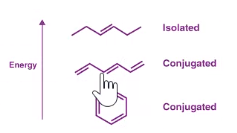
자유전자가 어느정도 있는지..


Generate graphs

Before we can generate complete graphs from SMILES, we need to implement the following functions:

    1. molecule_from_smiles, which takes as input a SMILES and returns a molecule object. This is all handled by RDKit.

    2.graph_from_molecule, which takes as input a molecule object and returns a graph, represented as a three-tuple (atom_features, bond_features, pair_indices). For this we will make use of the classes defined previously.

Finally, we can now implement the function graphs_from_smiles, which applies function (1) and subsequently (2) on all SMILES of the training, validation and test datasets.

Notice: although scaffold splitting is recommended for this data set (see here), for simplicity, simple random splittings were performed.

In [4]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].p_np

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].p_np

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

Test the functions

Name:	acetylsalicylate
SMILES:	CC(=O)Oc1ccccc1C(O)=O
BBBP:	0
Molecule:


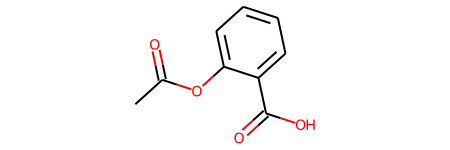

In [5]:
print(f"Name:\t{df.name[100]}\nSMILES:\t{df.smiles[100]}\nBBBP:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

In [6]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (13, 29)
	bond features	 (39, 7)
	pair indices	 (39, 2)


### Create a tf.data.Dataset
In this tutorial, the MPNN implementation will take as input (per iteration) a single graph. Therefore, given a batch of (sub)graphs (molecules), we need to merge them into a single graph (we'll refer to this graph as global graph). This global graph is a disconnected graph where each subgraph is completely separated from the other subgraphs.

In [7]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

### Model

The MPNN model can take on various shapes and forms. In this tutorial, we will implement an MPNN based on the original paper Neural Message Passing for Quantum Chemistry and DeepChem's MPNNModel. The MPNN of this tutorial consists of three stages: message passing, readout and classification.

Message passing
The message passing step itself consists of two parts:

    1. The edge network, which passes messages from 1-hop neighbors w_{i} of v to v, based on the edge features between them (e_{vw_{i}}), resulting in an updated node (state) v'. w_{i} denotes the i:th neighbor of v.

    2. The gated recurrent unit (GRU), which takes as input the most recent node state and updates it based on previous node states. In other words, the most recent node state serves as the input to the GRU, while the previous node states are incorporated within the memory state of the GRU. This allows information to travel from one node state (e.g., v) to another (e.g., v'').

Importantly, step (1) and (2) are repeated for k steps, and where at each step 1...k, the radius (or number of hops) of aggregated information from v increases by 1.

In [8]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

판독
메시지 전달 프로시저가 종료되면 k-단계 집계 노드 상태가 분할됩니다 하위 그래프(배치의 각 분자에 해당)로 변환한 후 그래프 수준 임베딩으로 축소되었습니다. 원본 논문에서는 이러한 목적으로 세트 투 세트 레이어가 사용되었습니다. 그러나 이 자습서에서는 트랜스포머 인코더 + 평균 풀링이 사용됩니다. 특히:

- k-step 집계 노드 상태는 하위 그래프로 분할됩니다 (배치의 각 분자에 해당);
- 그런 다음 각 하위 그래프는 노드 수가 가장 많은 하위 그래프와 일치하도록 채워집니다 작성자 a tf.stack(...);
- (누적된 패딩된) 텐서, 인코딩 서브그래프(각 서브그래프는 노드 상태 세트를 포함함)는 다음과 같습니다. 패딩이 훈련을 방해하지 않도록 마스킹합니다.
- 마지막으로 텐서는 트랜스포머에 전달되고 평균 풀링이 이어집니다.

In [9]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

MPNN(메시지 전달 신경망)Message Passing Neural Network (MPNN)
이제 MPNN 모델을 완성할 차례입니다. 메시지 전달 외에도 그리고 판독, 2층 분류 네트워크가 구현되어 BBBP의 예측.

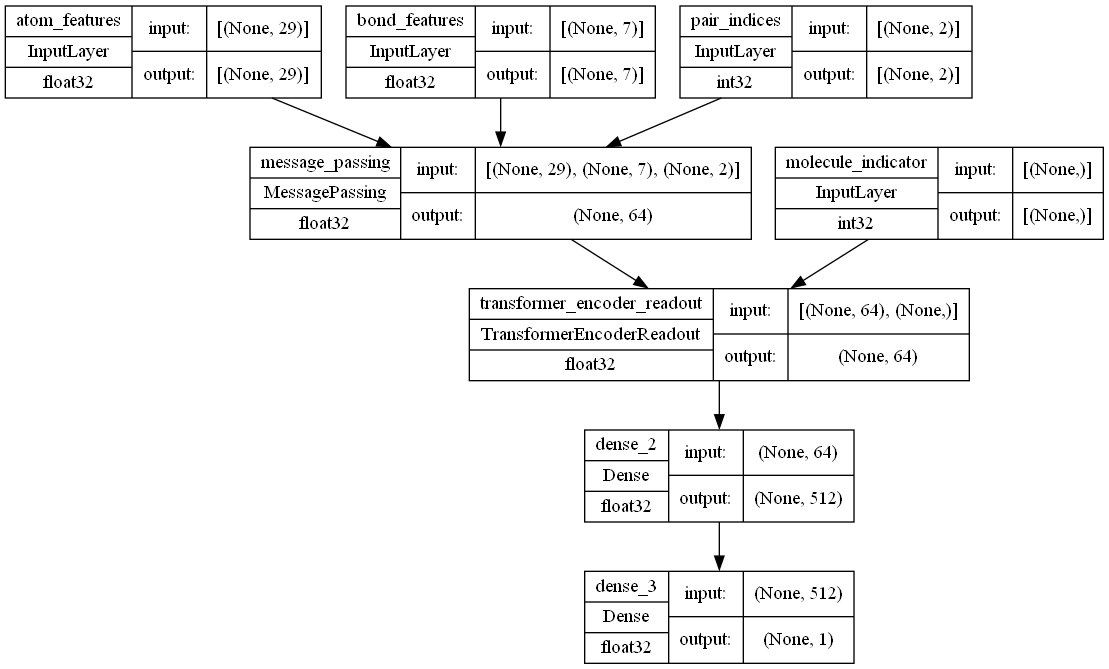

In [10]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

훈련

Epoch 1/40
52/52 - 10s - loss: 0.5440 - AUC: 0.6941 - val_loss: 0.6049 - val_AUC: 0.8314 - 10s/epoch - 183ms/step
Epoch 2/40
52/52 - 1s - loss: 0.4723 - AUC: 0.7842 - val_loss: 0.5996 - val_AUC: 0.8385 - 1s/epoch - 28ms/step
Epoch 3/40
52/52 - 1s - loss: 0.4546 - AUC: 0.8019 - val_loss: 0.6002 - val_AUC: 0.8478 - 1s/epoch - 28ms/step
Epoch 4/40
52/52 - 1s - loss: 0.4447 - AUC: 0.8120 - val_loss: 0.5388 - val_AUC: 0.8546 - 1s/epoch - 28ms/step
Epoch 5/40
52/52 - 1s - loss: 0.4346 - AUC: 0.8230 - val_loss: 0.4530 - val_AUC: 0.8641 - 1s/epoch - 28ms/step
Epoch 6/40
52/52 - 1s - loss: 0.4255 - AUC: 0.8320 - val_loss: 0.4473 - val_AUC: 0.8682 - 1s/epoch - 28ms/step
Epoch 7/40
52/52 - 1s - loss: 0.4167 - AUC: 0.8419 - val_loss: 0.5088 - val_AUC: 0.8633 - 1s/epoch - 28ms/step
Epoch 8/40
52/52 - 1s - loss: 0.4057 - AUC: 0.8538 - val_loss: 0.6124 - val_AUC: 0.8700 - 1s/epoch - 28ms/step
Epoch 9/40
52/52 - 1s - loss: 0.3975 - AUC: 0.8593 - val_loss: 0.5551 - val_AUC: 0.8779 - 1s/epoch - 28ms/ste

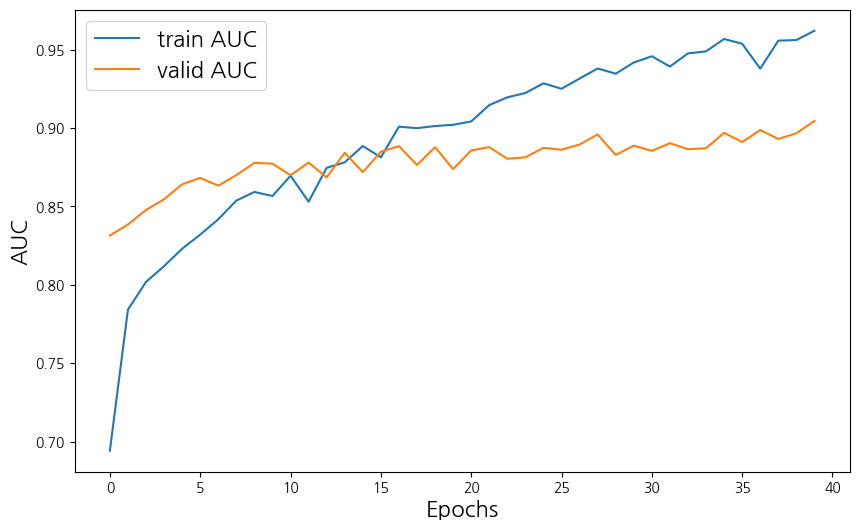

In [11]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    class_weight={0: 2.0, 1: 0.5},
)

plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

예측

1/1 [==============================] - 1s 659ms/step


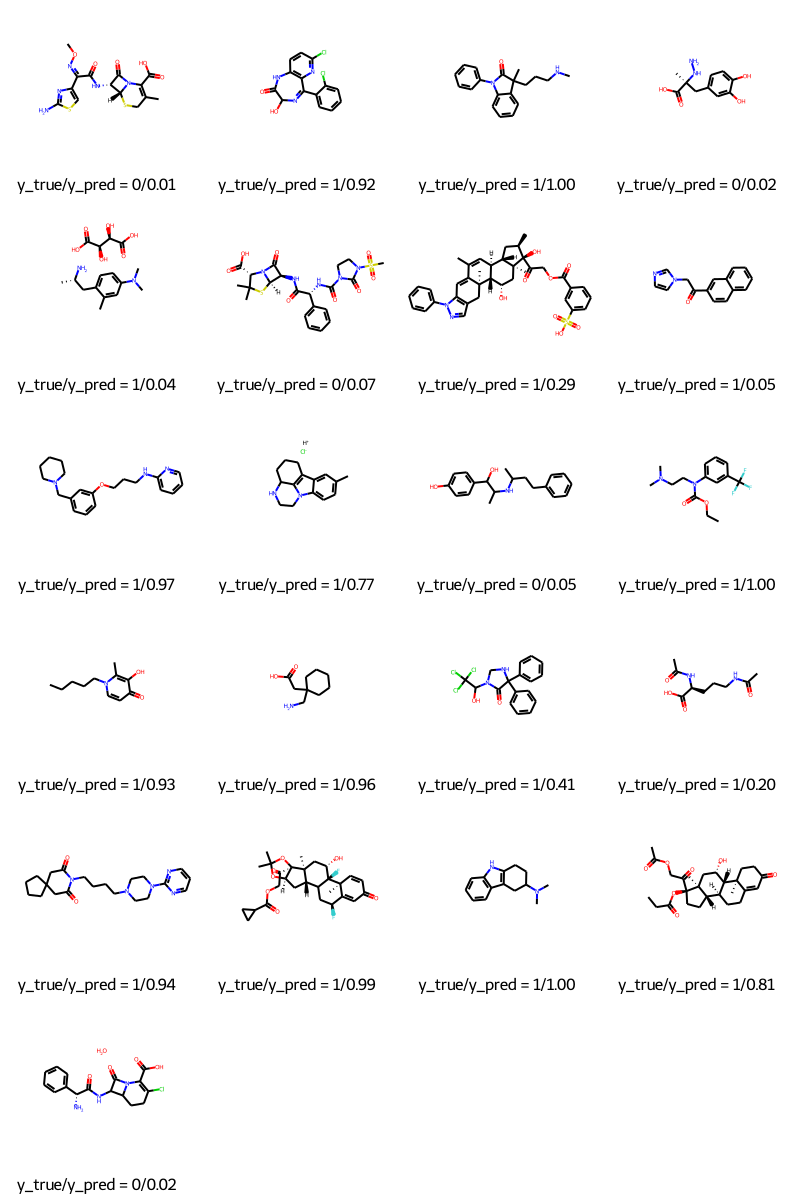

In [12]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

https://process-mining.tistory.com/164

https://paperswithcode.com/paper/neural-message-passing-for-quantum-chemistry#code

https://data-newbie.tistory.com/706